# Clairvoyante (Visualization)


In [2]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import time
import numpy as np
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [5]:
#import clairvoyante
import clairvoyante.utils_v2 as utils
import clairvoyante.clairvoyante_v3 as cv
import clairvoyante.param as param

## Load a trained model

In [6]:
# Load a trained model into memory
m = cv.Clairvoyante()
m.init()
m.restoreParameters("../trainedModels/fullv3-illumina-novoalign-hg001-hg38/full-round4-000098")

INFO:tensorflow:Restoring parameters from ../trainedModels/fullv3-illumina-novoalign-hg001-hg38/full-round4-000098


INFO:tensorflow:Restoring parameters from ../trainedModels/fullv3-illumina-novoalign-hg001-hg38/full-round4-000098


## Show number of parameters in the model

In [3]:
# Show the number of parameters of the model
r = tf.train.NewCheckpointReader("../trainedModels/fullv3-illumina-novoalign-hg001-hg38/full-round4-000098")
p = r.get_variable_to_shape_map()
tot = 0
for k, v in sorted(p.items(), key=lambda x: x[0]):
    if 'Momentum' not in k and\
       'global_step' not in k and\
       'Adam' not in k and\
       'power' not in k:
        tmp = np.prod(v)
        tot += tmp
        print >> sys.stderr, '%s: %s => %d' % (k, str(v), tmp)
print >> sys.stderr, 'Total number of parameters: %d' % tot

YBaseChangeSigmoid/bias: [4] => 4
YBaseChangeSigmoid/kernel: [336, 4] => 1344
YIndelLengthFC/bias: [6] => 6
YIndelLengthFC/kernel: [168, 6] => 1008
YVarTypeFC/bias: [4] => 4
YVarTypeFC/kernel: [168, 4] => 672
YZygosityFC/bias: [2] => 2
YZygosityFC/kernel: [168, 2] => 336
conv1/bias: [16] => 16
conv1/kernel: [1, 4, 4, 16] => 256
conv2/bias: [32] => 32
conv2/kernel: [2, 4, 16, 32] => 4096
conv3/bias: [48] => 48
conv3/kernel: [3, 4, 32, 48] => 18432
fc4/bias: [336] => 336
fc4/kernel: [4608, 336] => 1548288
fc5/bias: [168] => 168
fc5/kernel: [336, 168] => 56448
Total number of parameters: 1631496


## Load a dataset

In [4]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("../training/tensor_can_chr22",
                       "../training/var_chr22",
                       "../training/bed",
                       shuffle = False)

## Show the tensors of a variant

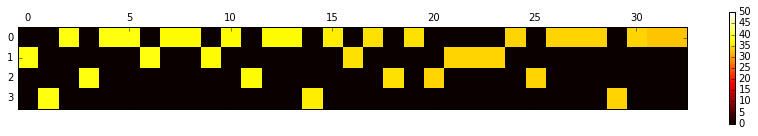

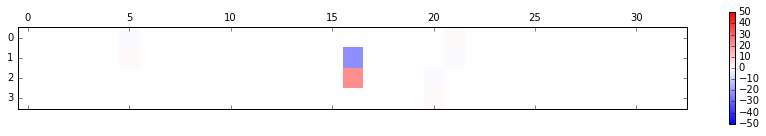

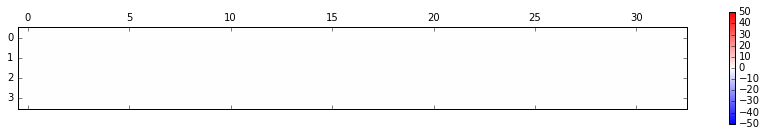

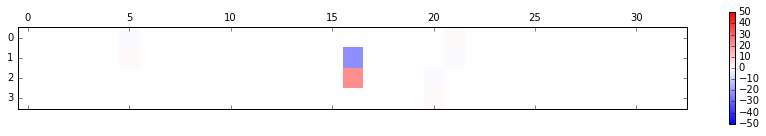

In [10]:
# Show how the four matrices are like
i = 1234
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

figure(figsize=(15, 8));
plt.subplot(4,1,1); plt.xticks(np.arange(0, 33, 1)); plt.yticks(np.arange(0, 4, 1), ['A','C','G','T'])
plt.imshow(XArray[0,:,:,0].transpose(), vmin=0, vmax=50, interpolation="nearest", cmap=cm.hot); colorbar()
plt.subplot(4,1,2); plt.xticks(np.arange(0, 33, 1)); plt.yticks(np.arange(0, 4, 1), ['A','C','G','T'])
plt.imshow(XArray[0,:,:,1].transpose(), vmin=-50, vmax=50, interpolation="nearest", cmap=cm.bwr); colorbar()
plt.subplot(4,1,3); plt.xticks(np.arange(0, 33, 1)); plt.yticks(np.arange(0, 4, 1), ['A','C','G','T'])
plt.imshow(XArray[0,:,:,2].transpose(), vmin=-50, vmax=50, interpolation="nearest", cmap=cm.bwr); colorbar()
plt.subplot(4,1,4); plt.xticks(np.arange(0, 33, 1)); plt.yticks(np.arange(0, 4, 1), ['A','C','G','T'])
plt.imshow(XArray[0,:,:,3].transpose(), vmin=-50, vmax=50, interpolation="nearest", cmap=cm.bwr); colorbar()

## Predict variants

In [10]:
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)

print >> sys.stderr, "Testing on the training and validation dataset ..."
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print >> sys.stderr, "Prediciton time elapsed: %.2f s" % (time.time() - predictStart)

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print >> sys.stderr, "Version 2 model, evaluation on base change:"
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print >> sys.stderr, "all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100)
print >> sys.stderr, "Version 2 model, evaluation on Zygosity:"
ed = np.zeros( (2,2), dtype=np.int )
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(2)])
print >> sys.stderr, "Version 2 model, evaluation on variant type:"
ed = np.zeros( (4,4), dtype=np.int )
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(4)])
print >> sys.stderr, "Version 2 model, evaluation on indel length:"
ed = np.zeros( (6,6), dtype=np.int )
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print >> sys.stderr, "\t".join([str(ed[i][j]) for j in range(6)])

Testing on the training and validation dataset ...
Prediciton time elapsed: 28.39 s
Version 2 model, evaluation on base change:
all/top1/top2/top1p/top2p: 69761/59304/69748/85.01/99.98
Version 2 model, evaluation on Zygosity:
23896	16
39	45810
Version 2 model, evaluation on variant type:
35182	42	0	1
11	34431	0	0
0	2	70	0
1	0	0	21
Version 2 model, evaluation on indel length:
69666	1	0	0	0	0
1	52	0	0	0	1
1	2	14	0	0	0
1	0	0	4	1	1
0	0	1	0	4	0
1	0	0	0	0	10


## Visualizing predictions

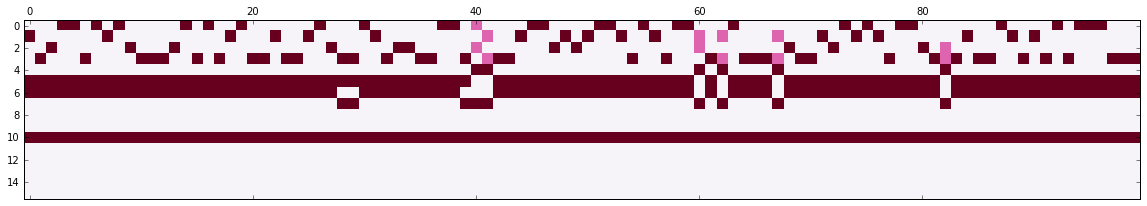

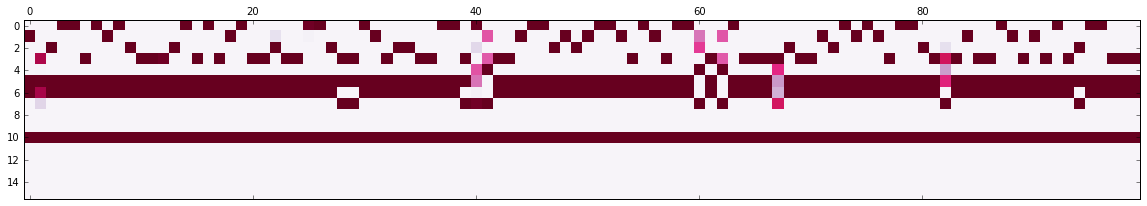

In [11]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],zs[arrayStart:arrayEnd,:],\
                         ts[arrayStart:arrayEnd,:],ls[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)

## Visualizing Hidden Layers

In [11]:
def GetActivations(layer, batchX):
    # Version 2 network
    '''
    units = m.session.run(layer, feed_dict={m.XPH:batchX,
                                            m.phasePH:False,
                                            m.dropoutRatePH:0.0})
    '''
    
    # Version 3 network
    units = m.session.run(layer, feed_dict={m.XPH:batchX,
                                            m.phasePH:False,
                                            m.dropoutRateFC4PH:0.0,
                                            m.dropoutRateFC5PH:0.0,
                                            m.l2RegularizationLambdaPH:0.0})
    return units

def PlotFiltersConv(units, interval=1, xsize=18, ysize=20):
    matplotlib.rc('ytick', labelsize=10)
    matplotlib.rc('xtick', labelsize=8)
    filters = units.shape[3]
    xlen = units.shape[2]
    plt.figure(1, figsize=(xsize,ysize))
    nColumns = 8
    nRows = math.ceil(filters / nColumns) + 1
    for i in range(filters):
        plt.subplot(nRows, nColumns, i+1)
        plt.title('Filter ' + str(i))
        plt.xticks(np.arange(0, xlen, interval), ['A','C','G','T'])
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap=cm.Purples)

def PlotFiltersFC(units, interval=10, xsize=18, ysize=4):
    matplotlib.rc('ytick', labelsize=10)
    matplotlib.rc('xtick', labelsize=8)
    plt.figure(1, figsize=(xsize,ysize))
    cell = units.shape[1]
    plt.xticks(np.arange(0, cell, interval))
    plt.yticks(np.arange(0, 1, 1), [''])
    plt.title(str(cell) + ' units')
    plt.imshow(np.reshape(units[0,:], (-1,cell)), interpolation="nearest", cmap=cm.Purples)

In [12]:
# Load a tensor
i = 0
XArray, _, _ = utils.DecompressArray(XArrayCompressed, i, 1, total)

Hidden layer shape:  (1, 33, 4, 16)


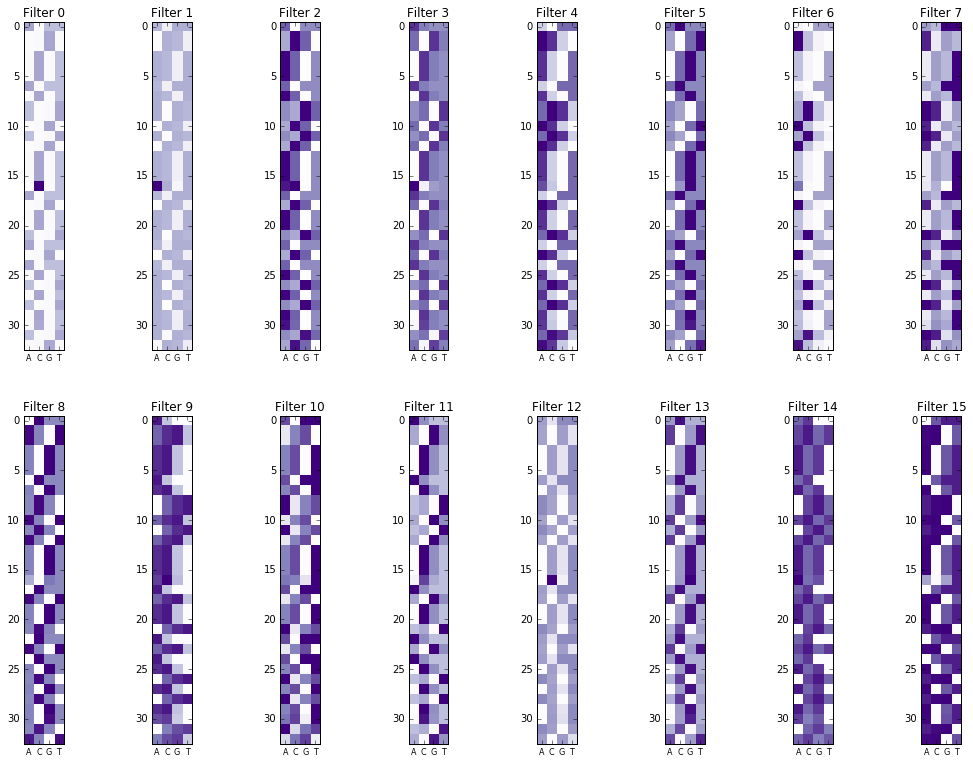

In [13]:
# Visualizing conv1
units = []
units = GetActivations(m.conv1, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersConv(units)

Hidden layer shape:  (1, 29, 4, 32)


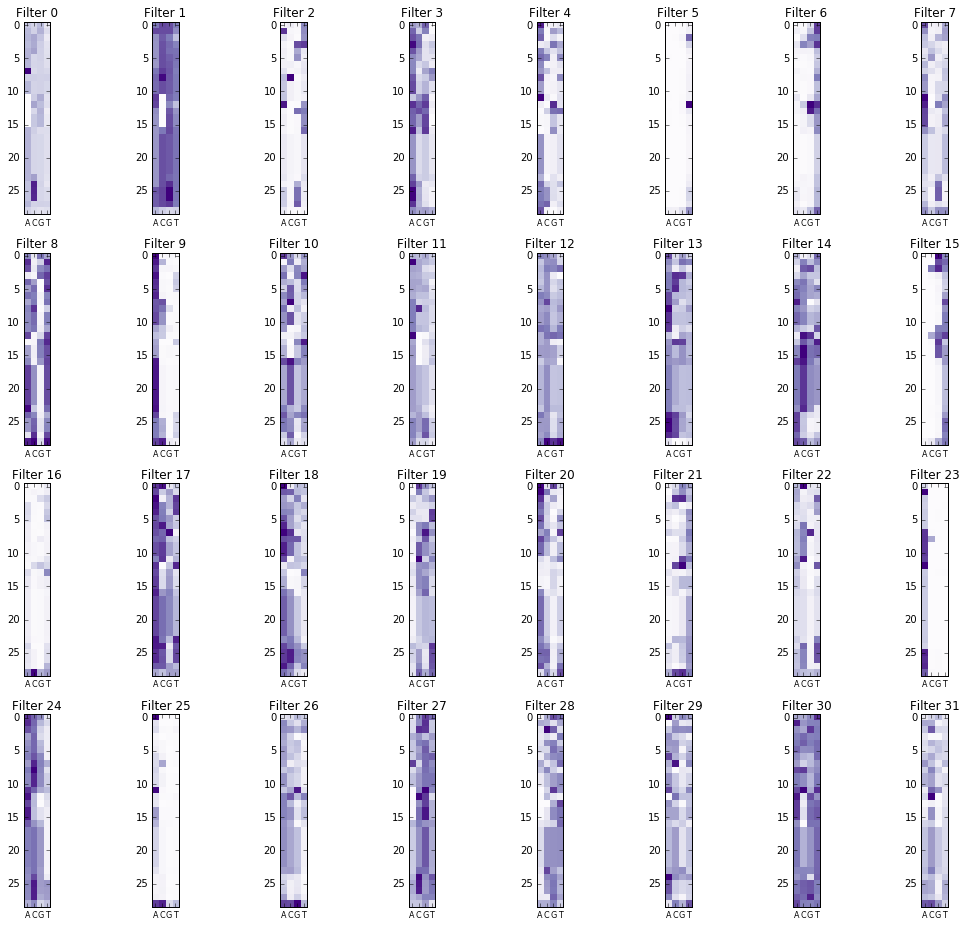

In [14]:
# Visualizing conv2
units = []
units = GetActivations(m.conv2, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersConv(units)

Hidden layer shape:  (1, 26, 4, 48)


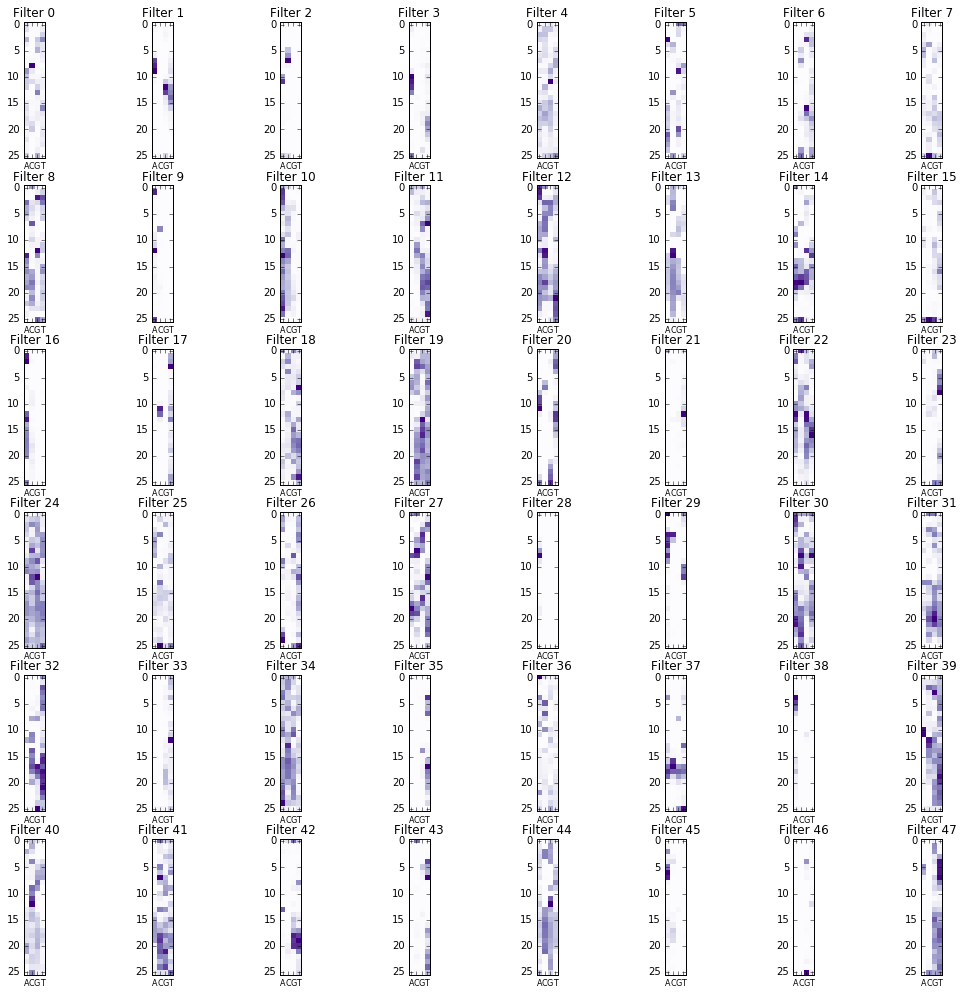

In [15]:
# Visualizing conv3
units = []
units = GetActivations(m.conv3, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersConv(units)

Hidden layer shape:  (1, 336)


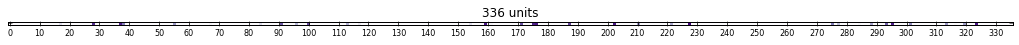

In [16]:
# Visualizing fc4
units = []
units = GetActivations(m.fc4, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersFC(units)

Hidden layer shape:  (1, 168)


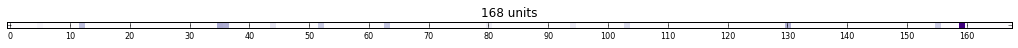

In [17]:
# Visualizing fc5
units = []
units = GetActivations(m.fc5, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersFC(units)

Hidden layer shape:  (1, 4)


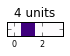

In [18]:
# Visualizing YBaseChangeSigmoid
units = []
units = GetActivations(m.YBaseChangeSigmoid, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersFC(units,2,1)

Hidden layer shape:  (1, 2)


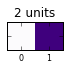

In [19]:
# Visualizing YZygositySoftmax
units = []
units = GetActivations(m.YZygositySoftmax, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersFC(units,1,1)

Hidden layer shape:  (1, 4)


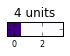

In [20]:
# Visualizing YVarTypeSoftmax
units = []
units = GetActivations(m.YVarTypeSoftmax, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersFC(units,2,1)

Hidden layer shape:  (1, 6)


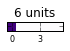

In [21]:
# Visualizing YIndelLengthSoftmax
units = []
units = GetActivations(m.YIndelLengthSoftmax, XArray)
print >> sys.stderr, "Hidden layer shape: ", units.shape
PlotFiltersFC(units,3,1)